Loading Training Set 

In [83]:
import pandas as pd
import numpy as np

#load training set
df = pd.read_csv("amazon_employee_access_train.csv") 

df.head()

X = df.drop(["ACTION"], axis = 1)
y = df["ACTION"]  
print(X.shape)
print(y.shape)

(32769, 9)
(32769,)


Splitting Sets using 3-way Holdout

In [74]:
import numpy as np
from sklearn.model_selection import train_test_split

#train + test

X_temp, X_test, y_temp, y_test = \
        train_test_split(X, y, test_size=0.2, 
                         shuffle=True, random_state=123, stratify=y)

#train + validate
X_train, X_valid, y_train, y_valid = \
        train_test_split(X_temp, y_temp, test_size=0.2,
                         shuffle=True, random_state=123, stratify=y_temp)

print('Train size', X_train.shape)
print('Valid size', X_valid.shape)
print('Test size', X_test.shape)

Train size (20972, 9)
Valid size (5243, 9)
Test size (6554, 9)


PCA 

Text(0, 0.5, 'Cumulative Explained Variance')

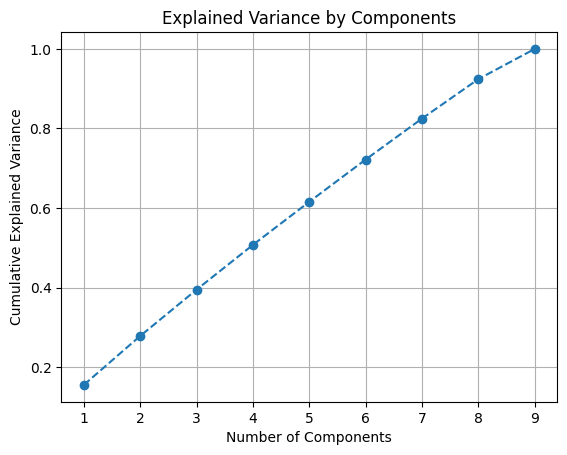

In [75]:
#Standardize 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

#perform PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_std)


#ouputs a expected variance by graph components
import matplotlib.pyplot as plt
plt.plot(range(1, 10), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle ='--')
plt.grid('both')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')



KNN

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, matthews_corrcoef


param_range = [1, 3, 5, 7, 9, 15, 21, 31] 

pipe_knn = make_pipeline(StandardScaler(),
                         PCA(n_components=7),   # since typically pick up to 80%, chose 7 comp. based on graph
                         KNeighborsClassifier())

param_grid = [{'kneighborsclassifier__n_neighbors': param_range}]

scorer = make_scorer(accuracy_score)

#Grid Search
gs_knn = GridSearchCV(estimator=pipe_knn,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)

#best score 
gs_knn = gs_knn.fit(X_train, y_train)
print('Training Score: ', gs.best_score_)
print(gs.best_params_)

#evaluate on test set
print("Test Accuracy: %0.2f" % gs.score(X_test, y_test))
PYDEVD_DISABLE_FILE_VALIDATION=1


Training Score:  0.9421133190862792
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_split': 2}
Test Accuracy: 0.94


Decision Tree Classifier

In [77]:
# Decision Tree Classifier Model
from sklearn.tree import DecisionTreeClassifier

#set up parameter grid
criterion_range = ["gini", "entropy", "log_loss"]  
max_depth_range =[None, 3, 5, 7, 10] # range of depths
min_samples_range = [2, 4, 6, 8, 10] # min samples per split

param_grid = {
    'decisiontreeclassifier__criterion': criterion_range,
    'decisiontreeclassifier__max_depth': max_depth_range,
    'decisiontreeclassifier__min_samples_split': min_samples_range}


pipe_tree = make_pipeline( StandardScaler(), PCA(n_components=7), DecisionTreeClassifier())

gs_tree = GridSearchCV(estimator=pipe_tree,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)

# best parameters and score
gs = gs_tree.fit(X_train, y_train)
print('Training Score: ', gs.best_score_)
print(gs.best_params_)

#evaluate on test set
best_tree=gs.best_estimator_
print("Test Accuracy: %0.2f" % best_tree.score(X_test, y_test))
PYDEVD_DISABLE_FILE_VALIDATION=1

Training Score:  0.9421133190862792
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_split': 2}
Test Accuracy: 0.94


Bagging

In [78]:
# Bagging Model
from sklearn.ensemble import BaggingClassifier
bestTree = DecisionTreeClassifier(criterion='entropy', # from previous best parameters
                              max_depth=3,
                              min_samples_split = 2,
                              random_state= 1)


pipe_bagging = make_pipeline( StandardScaler(), PCA(n_components=7), 
                    BaggingClassifier(estimator=bestTree,
                        n_estimators=100,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1))

pipe_bagging.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % pipe_bagging.score(X_test, y_test))

Test Accuracy: 0.94


Random Forest 

In [79]:
#Randorm Forest Model
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,
                                random_state=1)

forest.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % forest.score(X_test, y_test))

Test Accuracy: 0.95


Stacking

In [80]:
#Stacking Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier


clf1 = pipe_knn
clf2 = pipe_tree
clf3 = forest
clf4 = pipe_bagging


lr = LogisticRegression(random_state=1)

estimators = [('clf1', clf1),
              ('clf2', clf2),
              ('clf3', clf3),
              ('clf4', clf4),
             ]

sclf = StackingClassifier(estimators=estimators, 
                          final_estimator=lr, 
                          cv=10)


sclf.fit(X_train, y_train)
print("Train Accuracy: %0.2f" % sclf.score(X_train, y_train))
print("Test Accuracy: %0.2f" % sclf.score(X_test, y_test))

Train Accuracy: 0.99
Test Accuracy: 0.95


Evaluate best model on Test Set

In [81]:
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, matthews_corrcoef
# TODO

y_pred = sclf.predict(X_test)


print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))
print('MCC: %.3f' % matthews_corrcoef(y_true=y_test, y_pred=y_pred))

Accuracy: 0.948
Precision: 0.937
Recall: 0.948
F1: 0.939
MCC: 0.389


Confusion Matrix 

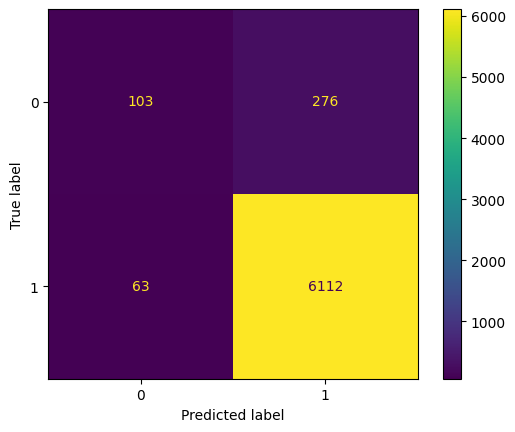

In [82]:
from sklearn.metrics import confusion_matrix
# TODO
confmat = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confmat,
                                      display_labels=sclf.classes_)
disp.plot()
plt.show()

Below Code used to create example test data set

In [ ]:
test_data=train_data.sample(n=58922, random_state=123)
test_data.to_csv("amazon_employee_access_test.csv", index=False)